In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from pmdarima.arima import auto_arima

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [112]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam
0,0,-3.528878,0.067576,0.932560,25.2
1,1,-4.131134,0.071671,1.029626,26.9
2,2,-3.964852,0.073103,1.023653,27.9
3,3,-3.710638,0.079740,0.989072,28.6
4,4,-3.307759,0.077855,0.967257,25.3


<Axes: >

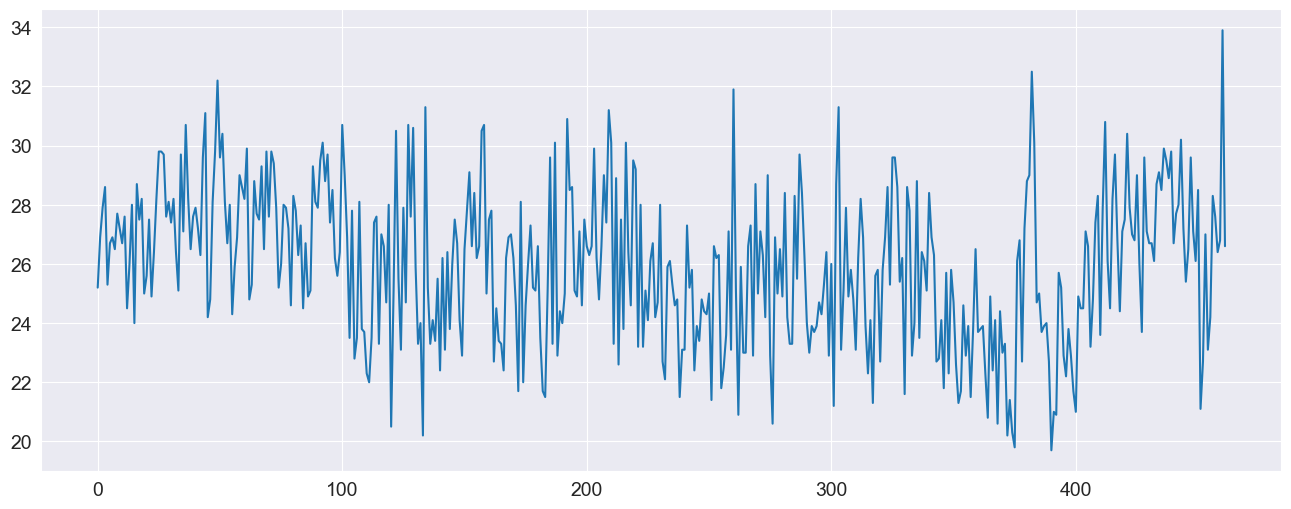

In [113]:
data15.CUM_Steam.plot()

In [114]:
delta_mean = data15['Delta'].mean()
delta_std = data15['Delta'].std()

damkohler_mean = data15['Damkohler'].mean()
damkohler_std = data15['Damkohler'].std()

sigma_mean = data15['Sigma'].mean()
sigma_std = data15['Sigma'].std()

steam_mean = data15['CUM_Steam'].mean()
steam_std = data15['CUM_Steam'].std()

In [115]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [116]:
data15.head()

,Delta,Damkohler,Sigma,CUM_Steam
Time,,,,
2023-01-01 00:00:00,-3.528878,0.067576,0.932560,25.2
2023-01-01 00:01:00,-4.131134,0.071671,1.029626,26.9
2023-01-01 00:02:00,-3.964852,0.073103,1.023653,27.9
2023-01-01 00:03:00,-3.710638,0.079740,0.989072,28.6
2023-01-01 00:04:00,-3.307759,0.077855,0.967257,25.3


In [117]:
data15_train = data15[:416]
data15_test = data15[416:]

In [118]:
data15_train.tail()

,Delta,Damkohler,Sigma,CUM_Steam
Time,,,,
2023-01-01 06:51:00,-0.021616,0.416164,1.017201,27.9
2023-01-01 06:52:00,-12.215373,0.048231,1.197968,30.8
2023-01-01 06:53:00,-5.959367,0.059172,1.009257,26.1
2023-01-01 06:54:00,-2.450689,0.085185,0.834601,24.5
2023-01-01 06:55:00,-0.086816,0.423440,1.032725,28.2


In [119]:
data15_test.head

<bound method NDFrame.head of                          Delta  Damkohler     Sigma  CUM_Steam
Time                                                          
2023-01-01 06:56:00  -5.034012   0.053259  0.951711       29.7
2023-01-01 06:57:00  -4.739834   0.056852  0.917188       26.8
2023-01-01 06:58:00  -5.168605   0.056303  0.921050       24.4
2023-01-01 06:59:00  -5.803137   0.055113  0.996934       27.1
2023-01-01 07:00:00  -5.162786   0.064888  1.008084       27.5
2023-01-01 07:01:00  -4.206190   0.070673  1.010822       30.4
2023-01-01 07:02:00  -2.762567   0.110648  0.953408       27.9
2023-01-01 07:03:00  -4.409840   0.072730  0.990977       27.0
2023-01-01 07:04:00  -6.259200   0.061253  1.044776       26.8
2023-01-01 07:05:00  -4.123903   0.060108  0.938327       29.0
2023-01-01 07:06:00  -5.143986   0.054337  0.939801       26.0
2023-01-01 07:07:00  -3.126289   0.069968  0.840544       23.7
2023-01-01 07:08:00  -4.800748   0.064921  1.095741       29.6
2023-01-01 07:09:00  -3.2

### Stationarity

In [120]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.63047429718675,
 0.0001134554550077056,
 6,
 455,
 {'1%': -3.4448040131772584,
  '5%': -2.8679131843980197,
  '10%': -2.5701646673107112},
 2033.4817289174227)

### ACF

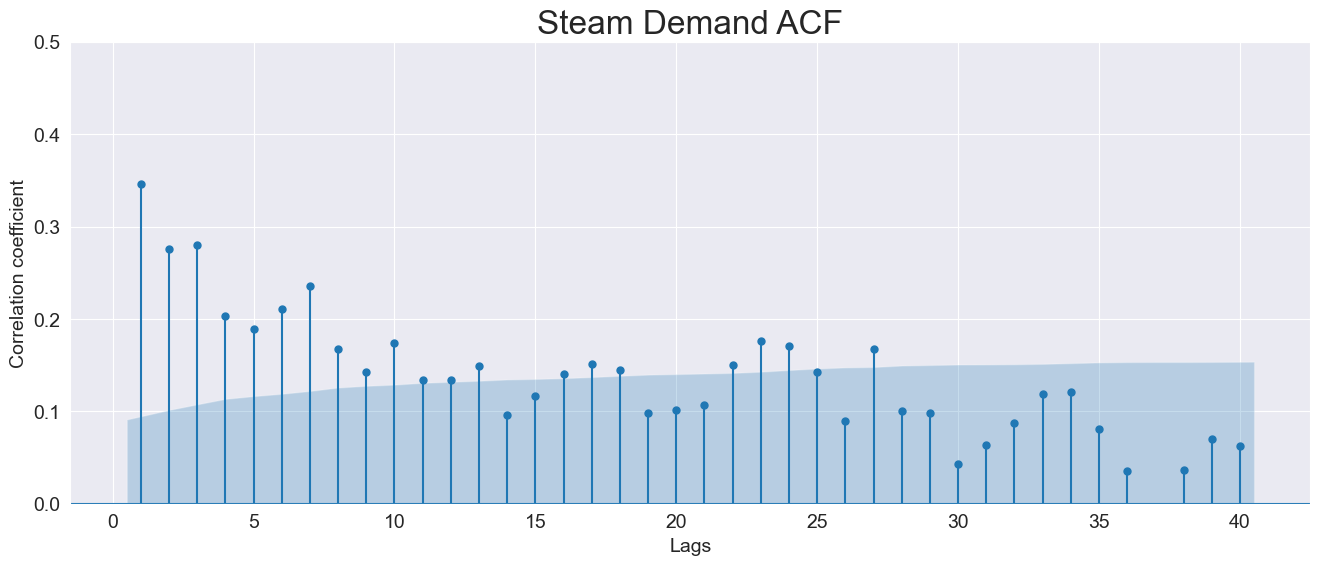

In [121]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("Steam Demand ACF", size = 24)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient')
plt.ylim(0, 0.5)
plt.show()

### PACF

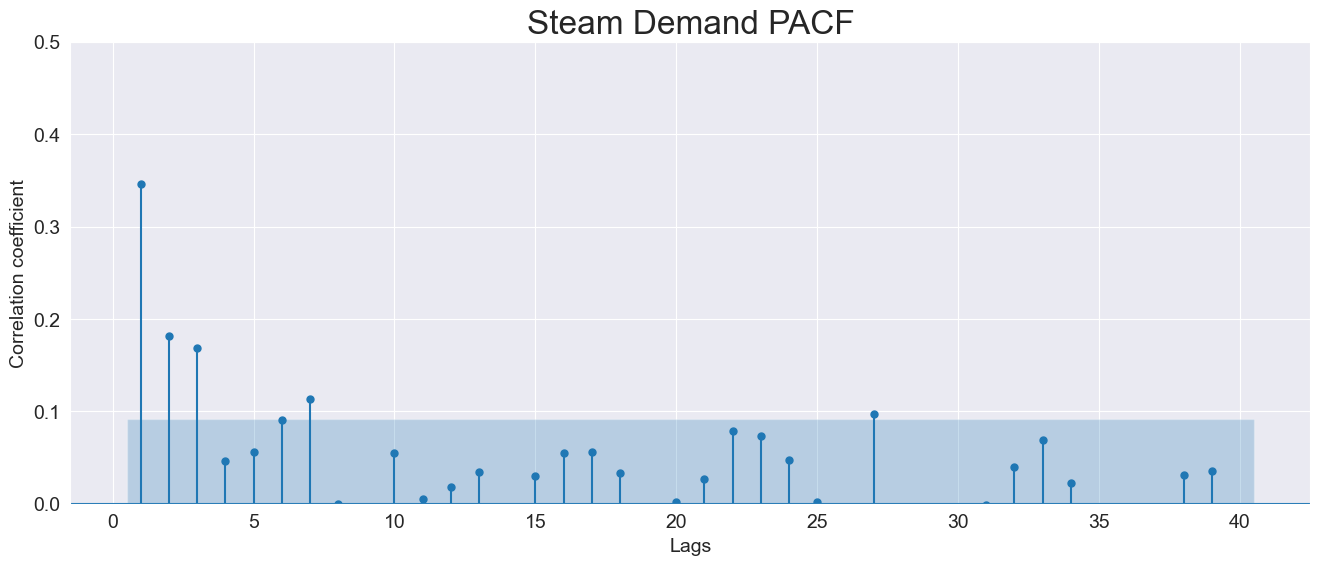

In [122]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("Steam Demand PACF", size = 24)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient')
plt.ylim(0, 0.5)
plt.show()

In [123]:
# print(data15_train.iloc[:,0])

In [124]:
# STANDARDIZATION
def preprocess(data):
    data.iloc[:,0] = (data.iloc[:,0] - delta_mean) / delta_std
    data.iloc[:,1] = (data.iloc[:,1] - damkohler_mean) / damkohler_std
    data.iloc[:,2] = (data.iloc[:,2] - sigma_mean) / sigma_std
    data.iloc[:,3] = (data.iloc[:,3] - steam_mean) / steam_std

    return data

preprocess(data15_train)
preprocess(data15_test)

,Delta,Damkohler,Sigma,CUM_Steam
Time,,,,
2023-01-01 06:56:00,-0.428321,-0.462186,0.056119,1.443191
2023-01-01 06:57:00,-0.305538,-0.437237,-0.248271,0.325704
2023-01-01 06:58:00,-0.484497,-0.441045,-0.214223,-0.599113
2023-01-01 06:59:00,-0.749335,-0.449312,0.454850,0.441306
2023-01-01 07:00:00,-0.482068,-0.381426,0.553159,0.595443
2023-01-01 07:01:00,-0.082808,-0.341250,0.577301,1.712930
2023-01-01 07:02:00,0.519725,-0.063638,0.071080,0.749579
2023-01-01 07:03:00,-0.167807,-0.326964,0.402321,0.402772
2023-01-01 07:04:00,-0.939685,-0.406673,0.876668,0.325704


In [125]:
# UNDO STANDARDIZATION
def undoprocess_data(arr):
    arr = (arr * steam_std) + steam_mean

    return arr

### ARIMA Models

In [126]:
# model_auto = auto_arima(data15_train.CUM_Steam)
# model_auto.summary()

In [127]:
model_arima = ARIMA(data15_train.CUM_Steam, order=(3, 1, 1))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  416
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -546.533
Date:                Wed, 10 Apr 2024   AIC                           1103.065
Time:                        01:58:34   BIC                           1123.206
Sample:                    01-01-2023   HQIC                          1111.030
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1874      0.048      3.898      0.000       0.093       0.282
ar.L2          0.0979      0.045      2.168      0.030       0.009       0.186
ar.L3          0.0879      0.052      1.685      0.0

### ARIMA311 Training Plots

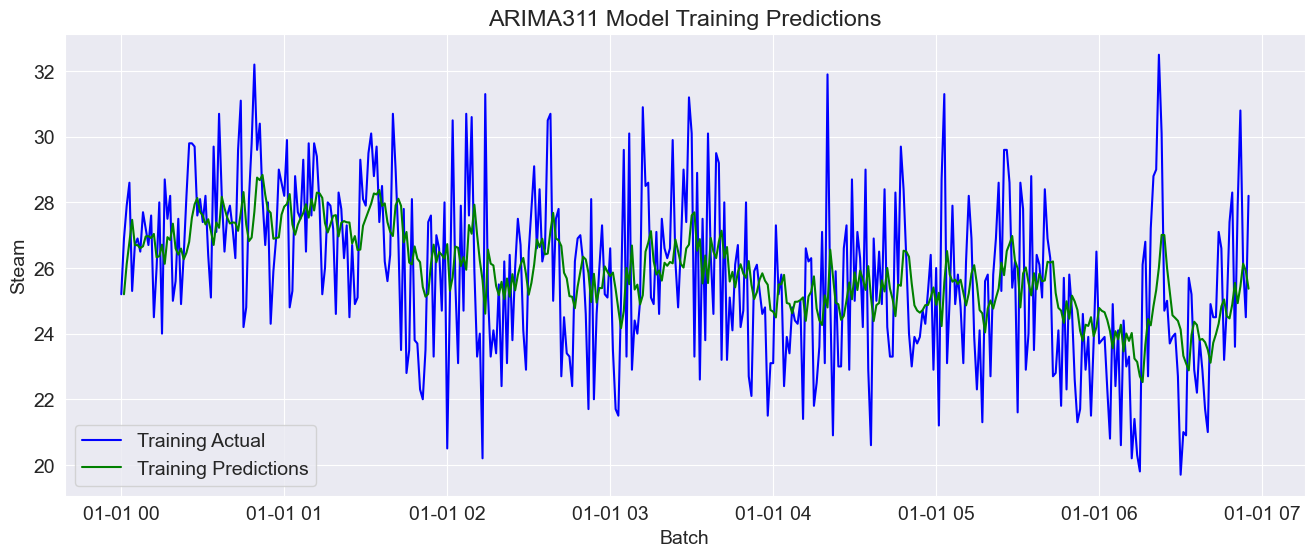

In [128]:
start_date = '2023-01-01 06:56:00'
end_date = '2023-01-01 07:41:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, undoprocess_data(data15_train['CUM_Steam']), color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], undoprocess_data(train_predictions['predicted_mean'].iloc[1:]), color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA311 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMA311 Training Performance

In [129]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(undoprocess_data(data15_train['CUM_Steam']), undoprocess_data(train_predictions['predicted_mean'])))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(undoprocess_data(data15_train['CUM_Steam']), undoprocess_data(train_predictions['predicted_mean']))

print('rmse', rmse)
print('mae', mae)

rmse 2.337526133000541
mae 1.9118293758177751


### ARIMA311 Test Plots

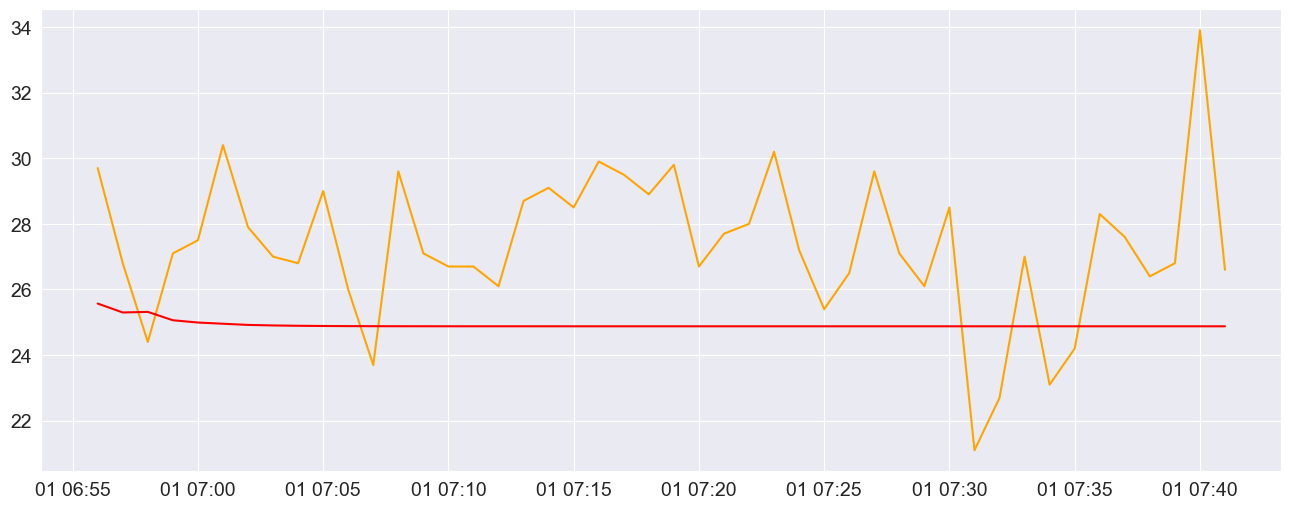

In [130]:
# Plot test data
plt.plot(data15_test.index, undoprocess_data(data15_test['CUM_Steam']), color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, undoprocess_data(test_predictions['predicted_mean']), color='red', label='Forecast')

# Show plot
plt.show()

### ARIMA311 Test Performance

In [131]:
# Calculate RMSE for every 5 data points in the test set
batch_size = 5
num_batches = len(data15_test) // batch_size
test_rmse_batches = []
test_mae_batches = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch_test_data = data15_test[start_idx:end_idx]
    batch_test_predictions = undoprocess_data(results_arima.predict(start=batch_test_data.index[0], end=batch_test_data.index[-1]))

    batch_test_rmse = np.sqrt(mean_squared_error(undoprocess_data(batch_test_data['CUM_Steam']), batch_test_predictions))
    batch_test_mae = mean_absolute_error(undoprocess_data(batch_test_data['CUM_Steam']), batch_test_predictions)

    test_rmse_batches.append(batch_test_rmse)
    test_mae_batches.append(batch_test_mae)

# Print RMSE for each batch
for i, rmse in enumerate(test_rmse_batches):
    print(f'Batch {i+1} Test RMSE: {rmse:.4f}')

print('\n')

# Print RMSE for each batch
for i, mae in enumerate(test_mae_batches):
    print(f'Batch {i+1} Test MAE: {mae:.4f}')

# Average RMSE across batches
avg_rmse = np.mean(test_rmse_batches)
print(f'\nAverage Test RMSE across batches: {avg_rmse:.4f}')

# Average MAE across batches
avg_rmse = np.mean(test_mae_batches)
print(f'\nAverage Test MAE across batches: {avg_rmse:.4f}')

Batch 1 Test RMSE: 2.4728
Batch 2 Test RMSE: 3.5621
Batch 3 Test RMSE: 2.5753
Batch 4 Test RMSE: 3.1732
Batch 5 Test RMSE: 4.2493
Batch 6 Test RMSE: 3.2151
Batch 7 Test RMSE: 2.9821
Batch 8 Test RMSE: 2.3301
Batch 9 Test RMSE: 4.6153


Batch 1 Test MAE: 2.2180
Batch 2 Test MAE: 3.3073
Batch 3 Test MAE: 2.2117
Batch 4 Test MAE: 2.9413
Batch 5 Test MAE: 4.0815
Batch 6 Test MAE: 2.8215
Batch 7 Test MAE: 2.6815
Batch 8 Test MAE: 2.1071
Batch 9 Test MAE: 3.7215

Average Test RMSE across batches: 3.2417

Average Test MAE across batches: 2.8990


### ARIMAX with all Parameters

In [132]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Damkohler', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(3,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  416
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -382.545
Date:                Wed, 10 Apr 2024   AIC                            781.090
Time:                        01:58:37   BIC                            813.317
Sample:                    01-01-2023   HQIC                           793.834
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta         -0.0979      0.038     -2.566      0.010      -0.173      -0.023
Damkohler     -0.1264      0.046     -2.776      0.006      -0.216      -0.037
Sigma          0.5840      0.029     20.040      0.000       0.527       0.641
ar.L1          0.1596      0.053      2.988      0.003       0.055       0.264
ar.L2          0.0882      0.047      1.865      0.062      -0.005       0.181
ar.L3          0.0109      0.051      0.216      0.829      -0.088       0.110
ma.L1         -0.9808      0.010    -93.548      0.000      -1.001      -0.960
sigma2         0.3675      0.028     13.249      0.000       0.313       0.422
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.96   Prob(JB):                         0.66
Heteroskedasticity (H):               0.88   Skew:                             0.09
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX311 with all parameters training plots

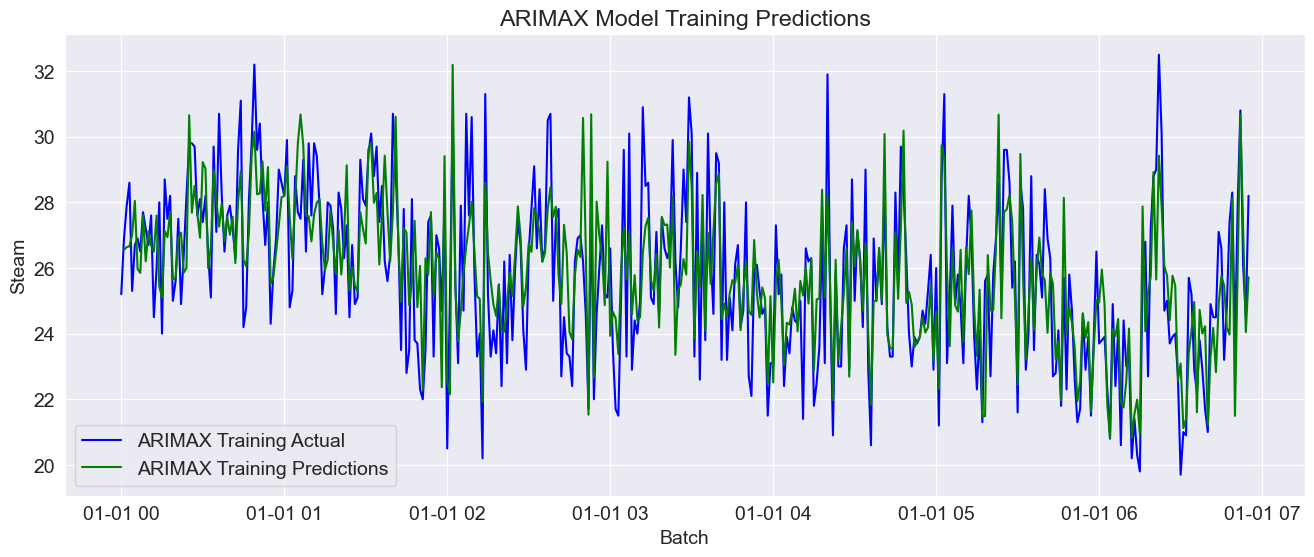

In [133]:
start_date = '2023-01-01 06:56:00'
end_date = '2023-01-01 07:41:00'
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, undoprocess_data(data15_train['CUM_Steam']), color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], undoprocess_data(train_predictions['predicted_mean'].iloc[1:]), color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [134]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(undoprocess_data(data15_train['CUM_Steam']), undoprocess_data(train_predictions['predicted_mean'])))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(undoprocess_data(data15_train['CUM_Steam']), undoprocess_data(train_predictions['predicted_mean']))

print('rmse', rmse)
print('mae', mae)

rmse 1.5748428325044124
mae 1.2565105826426604


### ARIMAX test plots

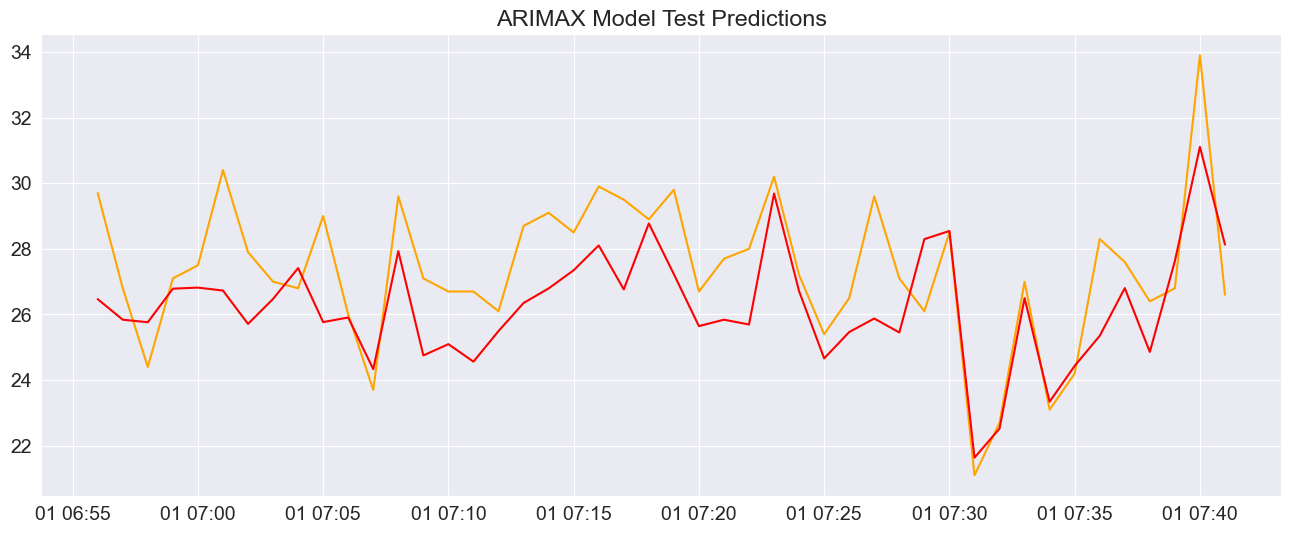

In [135]:
# Plot test data
plt.plot(data15_test.index, undoprocess_data(data15_test['CUM_Steam']), color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, undoprocess_data(arimax_test_predictions['predicted_mean']), color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

In [136]:
# residuals = data15_train['CUM_Steam'] - train_predictions['predicted_mean']

In [137]:
# # Create a histogram of residuals
# plt.figure(figsize=(8, 6))
# plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# # Add labels and title
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Histogram of Residuals')

# # Add a grid for better visualization
# plt.grid(True)

# # Show plot
# plt.show()

### Test Performance

In [138]:
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Sigma']]

# Calculate RMSE for every 5 data points in the test set
batch_size = 5
num_batches = len(data15_test) // batch_size
test_rmse_batches = []
test_mae_batches = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    
    batch_test_data = data15_test[start_idx:end_idx]
    batch_test_predictions = undoprocess_data(res_arimax.predict(start=start_idx, end=end_idx-1, exog=exog_vars_test.iloc[start_idx:end_idx]))

    batch_test_rmse = np.sqrt(mean_squared_error(undoprocess_data(batch_test_data['CUM_Steam']), batch_test_predictions))
    batch_test_mae = mean_absolute_error(undoprocess_data(batch_test_data['CUM_Steam']), batch_test_predictions)

    test_rmse_batches.append(batch_test_rmse)
    test_mae_batches.append(batch_test_mae)

# Print RMSE for each batch
for i, rmse in enumerate(test_rmse_batches):
    print(f'Batch {i+1} Test RMSE: {rmse:.4f}')

print('\n')

# Print RMSE for each batch
for i, mae in enumerate(test_mae_batches):
    print(f'Batch {i+1} Test MAE: {mae:.4f}')

# Average RMSE across batches
avg_rmse = np.mean(test_rmse_batches)
print(f'\nAverage Test RMSE across batches: {avg_rmse:.4f}')

# Average MAE across batches
avg_rmse = np.mean(test_mae_batches)
print(f'\nAverage Test MAE across batches: {avg_rmse:.4f}')

Batch 1 Test RMSE: 2.0154
Batch 2 Test RMSE: 1.9517
Batch 3 Test RMSE: 2.0765
Batch 4 Test RMSE: 1.8293
Batch 5 Test RMSE: 2.9591
Batch 6 Test RMSE: 1.6874
Batch 7 Test RMSE: 1.3812
Batch 8 Test RMSE: 4.3629
Batch 9 Test RMSE: 2.3544


Batch 1 Test MAE: 1.4531
Batch 2 Test MAE: 1.8076
Batch 3 Test MAE: 1.7903
Batch 4 Test MAE: 1.7243
Batch 5 Test MAE: 2.6532
Batch 6 Test MAE: 1.3901
Batch 7 Test MAE: 1.0908
Batch 8 Test MAE: 3.9095
Batch 9 Test MAE: 1.5491

Average Test RMSE across batches: 2.2909

Average Test MAE across batches: 1.9298
